In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split

import torchvision
import torchvision.transforms as transforms
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

from corruption_utils import corruptions

%load_ext autoreload
%autoreload 2

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
from src.model import Discriminator, Generator
from src.trainer import GAN, WGAN

In [4]:

from src.utils import generate_style_dict, KStyledMNIST, KStyledMNISTGenerator

In [5]:
np.random.seed(101)
torch.manual_seed(101)
mnist = torchvision.datasets.MNIST(
    "../data", train=True, download=True
)

style_fns = [
    corruptions.identity,
    corruptions.stripe,
    corruptions.zigzag,
    corruptions.canny_edges,
    lambda x: corruptions.scale(x, 5),
    corruptions.brightness,
]

In [6]:
def get_data_splits(k: int, seed: int):
    """
    Generate data splits and style dictionaries for k styled MNIST dataset

    Parameters:
        k (int): The number of styles to generate for each class
        seed (int): The random seed for reproducibility

    Returns:
        style_dict (dict): A dictionary containing the style information for each class
        train (k styled MNIST)
        valid (k styled MNIST)
        test (m-k styled MNIST)
    """
    np.random.seed(seed)
    torch.manual_seed(seed)
    mnist = torchvision.datasets.MNIST("../data", train=True)
    mnist_train, mnist_test = random_split(mnist, [50000, 10000])
    style_dict = generate_style_dict(classes=list(range(10)), style_fns=style_fns, k=k)
    mnist_generator = KStyledMNISTGenerator(mnist_train, style_dict, "train")
    train = KStyledMNIST(
        mnist_generator,
        transforms.Compose([transforms.ToTensor(), lambda img: img / 255.0]),
    )
    mnist_generator = KStyledMNISTGenerator(mnist_test, style_dict, "test")
    test = KStyledMNIST(
        mnist_generator,
        transforms.Compose([transforms.ToTensor(), lambda img: img / 255.0]),
    )
    train_size = int(0.85 * len(train))
    train, valid = random_split(train, [train_size, len(train) - train_size])
    return style_dict, train, valid, test

In [7]:
style_dict, train, valid, test = get_data_splits(k=1, seed=101)

Generating dataset: 100%|██████████| 10000/10000 [00:02<00:00, 4514.30item/s]


In [11]:
for i in style_dict.keys():
    print(i, style_dict[i]["train"])
    

0 [<function identity at 0x000002584FEAECB0>]
1 [<function zigzag at 0x000002584FEAE7A0>]
2 [<function canny_edges at 0x000002584FEAE9E0>]
3 [<function canny_edges at 0x000002584FEAE9E0>]
4 [<function stripe at 0x000002584FEAE950>]
5 [<function <lambda> at 0x000002584FEB43A0>]
6 [<function zigzag at 0x000002584FEAE7A0>]
7 [<function canny_edges at 0x000002584FEAE9E0>]
8 [<function stripe at 0x000002584FEAE950>]
9 [<function canny_edges at 0x000002584FEAE9E0>]


In [9]:
train_loader = DataLoader(train, batch_size=128, shuffle=True)

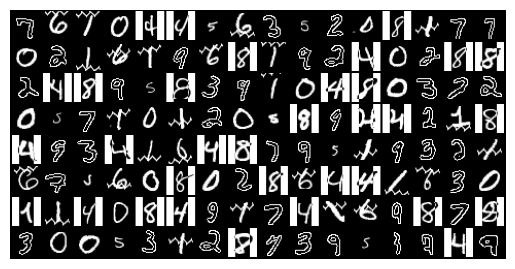

In [10]:
X, label, _ = next(iter(train_loader))
X = X.to(device)
label = label.to(device)

plt.imshow(
    make_grid(X.cpu(), nrow=16).permute(1, 2, 0)
)
plt.axis('off')
plt.show()

### GAN

In [ ]:
model = GAN(
    generator=Generator(z_dim=64),
    discriminator=Discriminator(),
    lr={"D": 2e-4, "G": 1e-4},
    verbose_period=2,
    device=device
)

In [ ]:
d_losses, g_losses = model.fit(15, train_loader)
pd.DataFrame(
    {"d_loss": d_losses, "g_loss": g_losses}
).plot(kind="line")
plt.show()

In [ ]:
z = torch.randn(128, model.generator.z_dim, 1, 1).to(device)
xhat = model.generator(z).detach().cpu()
plt.imshow(torch.permute(make_grid(xhat, nrow=16), (1, 2, 0)))
plt.show()

### WGAN-GP

In [12]:
model = WGAN(
    generator=Generator(z_dim=64),
    discriminator=Discriminator(gan_type="wasserstein"),
    lr={"D": 2e-4, "G": 1e-4},
    hyperparam={"lambda_gp": 10, "n_critic": 5},
    verbose_period=2,
    device=device
)

In [13]:
d_losses, g_losses = model.fit(17, train_loader)

Epoch 16: 100%|██████████| 333/333 [00:49<00:00,  6.73batch/s, d_loss=-2.47, g_loss=-6.24] 


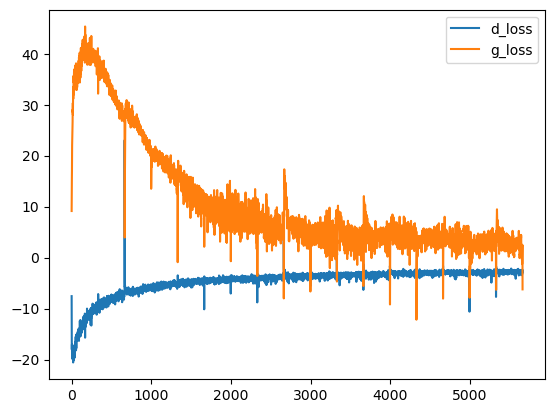

In [14]:
pd.DataFrame(
    {"d_loss": d_losses, "g_loss": g_losses}
).plot(kind="line")
plt.show()

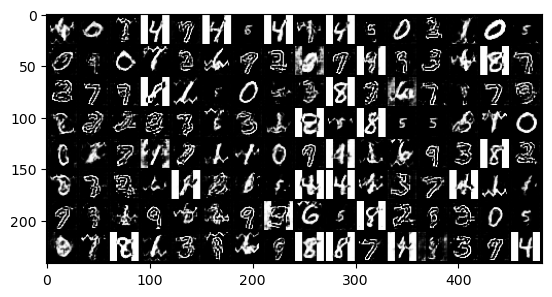

In [15]:
z = torch.randn(128, model.generator.z_dim, 1, 1).to(device)
xhat = model.generator(z).detach().cpu()
plt.imshow(torch.permute(make_grid(xhat, nrow=16), (1, 2, 0)))
plt.show()

In [ ]:
scores = model.disciminator(xhat.to(device)).squeeze()
scores

tensor(7.5279, device='cuda:0', grad_fn=<MeanBackward0>)

In [ ]:
test_loader = DataLoader(test, batch_size=128, shuffle=True)
model.disciminator(next(iter(test_loader))[0].to(device)).squeeze()

tensor(7.1114, device='cuda:0', grad_fn=<MeanBackward0>)

### CLEARInfoVAE

In [ ]:
from src.trainer import CLEARInfoGAN

In [ ]:
model = CLEARInfoGAN(
    z_dim=100,
    num_classes=10,
    lr=2e-5,
    hyperparam={"lambda_info": 0.5, "tau": 0.3},
    verbose_period=2,
    device=device
)

In [ ]:
d_losses, g_losses, q_losses = model.fit(13, train_loader)

In [ ]:
pd.DataFrame(
    {"d_loss": d_losses, "g_loss": g_losses, "q_loss": q_losses}
).plot(kind="line")
plt.show()

In [ ]:
model.generator.eval()
z_cs = []
labels = []

samples = []
with torch.no_grad():
    for i in range(10):
        digit_type = (torch.ones(16, dtype=torch.int64) * i).to(model.device)
        torch.manual_seed(1)
        z_raw = torch.randn(16, model.z_dim).to(model.device)
        label_onehot = nn.functional.one_hot(digit_type, 10).to(model.device)
        z_c = model.zc_encoder(torch.cat([z_raw, label_onehot], dim=-1))
        z_s = model.zs_encoder(torch.cat([z_raw, label_onehot], dim=-1))
        z = torch.cat([z_c, z_s], dim=1)[:, :, None, None]
        xhat = model.generator(z).detach().cpu()
        samples.append(xhat)
        z_cs.append(z_c)
        labels.append(digit_type)
z_cs = torch.cat(z_cs, dim=0)
labels = torch.cat(labels, dim=0)

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, init='pca')
z_cs_tsne = tsne.fit_transform(z_cs.cpu().numpy())
plt.scatter(z_cs_tsne[:, 0], z_cs_tsne[:, 1], alpha=0.3,
            c=labels.cpu().numpy(), cmap='tab10')
plt.colorbar(label='')

In [ ]:
plt.imshow(torch.permute(make_grid(torch.cat(samples, dim=0), nrow=16), (1, 2, 0)))
plt.axis('off')
plt.show()
